In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim import corpora, models, similarities, matutils
from gensim.models import CoherenceModel


import nltk
from nltk.corpus import stopwords

from pprint import pprint

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer


In [2]:
#Samaras Laptop
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\DIE_DATEN\datensatz.csv')
#song_data = song_data[(song_data['Language'] == 'en')]
#song_data.to_csv("outData.csv", index=False)
#song_data = pd.read_csv('C:\\Users\sdo\Studienarbeit\outData.csv')


#Anjas Laptop
# song_data = pd.read_csv('../Daten/train.csv')
# song_data = song_data[(song_data['Language'] == 'en')]
# song_data.to_csv("../Daten/outData.csv", index=False)
song_data = pd.read_csv('../Daten/cleanedData.csv')

## Get a balanced sample of 5 songs per genre

In [3]:
num_genres = song_data.Genre.nunique()
num_topics = num_genres
genres = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz', 'Metal', 'Pop', 'R&B', 'Rock']
topic_columns = [i for i in range(0, num_topics)]
label_lookup = {
    0: "Country",
    1: "Electronic",
    2: "Folk",
    3: "Hip-Hop",
    4: "Indie",
    5: "Jazz",
    6: "Metal",
    7: "Pop",
    8: "R&B",
    9: "Rock"
}

In [4]:
song_data = song_data[["Genre", "Lyrics"]]
song_data = song_data.groupby('Genre').sample(1000, random_state=42).reset_index(drop=True)
song_data.head(10)

,Genre,Lyrics
0,Country,IF YOU'RE GOIN' GIRL WRITER BOBBY BOND If you'...
1,Country,I'd rather live a life of lies and fantasy Tha...
2,Country,Well I'm making out my list For ole St.Nick to...
3,Country,Though you've gone away I play your favorite s...
4,Country,"DADDY'S LITTLE GIRL Writers Bobby Burke, Horac..."
5,Country,SANTA HO HO HO HO HO hohohohohohoho And what d...
6,Country,In a tiny town where the biggest things Were t...
7,Country,"(I sit here and look at you, lonely room it's ..."
8,Country,I've got this sensitive condition It's aggriva...
9,Country,"I'm traveling down this lonesome road, oh, how..."


## Remove punctuation/lower casing

In [5]:
song_data_processed = song_data.copy()
# removing everything except alphabets`
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("[^a-zA-Z#]", " ")
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].str.replace("\'", " ")
# removing short words (shorter than 3 characters)
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

# make all text lowercase
song_data_processed['Lyrics'] = song_data_processed['Lyrics'].apply(lambda x: x.lower())
song_data_processed

,Genre,Lyrics
0,Country,goin girl writer bobby bond goin girl summerti...
1,Country,rather live life lies fantasy than face truth ...
2,Country,well making list st.nick tonight afraid what w...
3,Country,though gone away play your favorite song blue ...
4,Country,"daddy little girl writers bobby burke, horace ..."
...,...,...
9995,Rock,said couldn find anyone love said there more l...
9996,Rock,caress inside bones caress inside bones house ...
9997,Rock,married fever hotter than pepper sprout been t...
9998,Rock,open your eyes life time flies open light back...


## Remove stopwords and Tokenize

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anjan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
stop_words = stopwords.words('english')
new_stop_words = ['ooh','oh','yeah','hey','whoa','woah', 'ohh', 'was', 'mmm', 'oooh','yah','yeh','mmm', 'hmm','deh','doh','jah','wa', 'intro', 'chorus', 'bridge', 'refrain']
stop_words.extend(new_stop_words)

max_df: je niedriger dieser Wert, desto mehr Mainstream wörter, die in allen songs vorkommen, werden nicht beachtet

In [8]:
#Turn Lyrics into vectorized form (based on counts)
count_vec = CountVectorizer(stop_words=stop_words, max_df=0.2, min_df=0.01, ngram_range=(1,1))
words_df = count_vec.fit_transform(song_data_processed.Lyrics)

In [9]:
words_df = words_df.transpose()
corpus = matutils.Sparse2Corpus(words_df)
id2word = dict((v, k) for k, v in count_vec.vocabulary_.items())
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes=100, random_state=11)

In [10]:
for topic_num, terms in lda.show_topics(formatted=False):
    print(f"Topic {topic_num}:", end=" ")
    for term, prob in terms:
        print(term, end=" ")
    print("")

Topic 0: home little well said long gone sing song lord town 
Topic 1: would still much things ever believe think always even better 
Topic 2: nigga shit fuck money niggas bitch bout real verse rock 
Topic 3: forever mine sweet true dream together beautiful miss world kiss 
Topic 4: keep dance high around fire hold coming round look move 
Topic 5: need give tonight show please help find waiting someone mind 
Topic 6: tell think something hear everything people talk inside name call 
Topic 7: baby girl gonna wanna gotta good tell alright wait little 
Topic 8: alone eyes light find rain lost left cold still fall 
Topic 9: world dead blood black stand soul death fight born power 


In [11]:
#umbrella term map for plotting
umbrella_topic_lookup = {
    0: "0-Heimatgefühle",
    1: "1-Persönliche Überzeugungen",
    2: "2-Straßenkultur und Slang",
    3: "3-Romantische Liebe",
    4: "4-Bewegung und Energie",
    5: "5-Erwartungen und Hoffnungen an andere",
    6: "6-Zwischenmenschliche Kommunikation",
    7: "7-Zukunftspläne in Beziehungen",
    8: "8-Gefühle der Einsamkeit",
    9: "9-Düstere Gedanken"
}

### Finding umbrella Terms for the Topics
•	Topic 0 – Heimatgefühle  
•	Topic 1 – Persönliche Überzeugungen  
•	Topic 2 – Straßenkultur und Slang    
•	Topic 3 – Romantische Liebe    
•	Topic 4 – Bewegung und Energie  
•	Topic 5 – Erwartungen und Hoffnungen an andere    
•	Topic 6 – Zwischenmenschliche Kommunikation    
•	Topic 7 – Zukunftspläne in Beziehungen    
•	Topic 8 – Gefühle der Einsamkeit    
•	Topic 9 – Düstere Gedanken    

### Auswertung Topics

In [12]:
docTopicProbMat = lda[corpus]
csr = matutils.corpus2csc(docTopicProbMat)
doc_top = csr.T.toarray()
doc_top_df = pd.DataFrame(doc_top, columns = [i for i in range(0, num_topics)])
results = pd.merge(song_data_processed, doc_top_df, left_index=True, right_index=True)
#Evaluate most dominant Topics
results['Dominant_Topic'] = results[[i for i in range(0, num_topics)]].idxmax(axis=1)
#Count number of appearing topics for each song
results['NonZeroTopics'] = (results.iloc[:, 2:12] != 0).sum(axis=1)
results.head(6)

,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,NonZeroTopics
0,Country,goin girl writer bobby bond goin girl summerti...,0.000000,0.266757,0.071641,0.000000,0.000000,0.000000,0.0,0.394076,0.246090,0.000000,7,4
1,Country,rather live life lies fantasy than face truth ...,0.107406,0.283561,0.000000,0.000000,0.189025,0.099175,0.0,0.000000,0.306939,0.000000,8,5
2,Country,well making list st.nick tonight afraid what w...,0.087120,0.000000,0.000000,0.258992,0.000000,0.155424,0.0,0.420491,0.058735,0.000000,7,5
3,Country,though gone away play your favorite song blue ...,0.423362,0.237056,0.000000,0.000000,0.000000,0.028630,0.0,0.000000,0.296995,0.000000,0,4
4,Country,"daddy little girl writers bobby burke, horace ...",0.490290,0.000000,0.000000,0.167493,0.000000,0.040951,0.0,0.219875,0.000000,0.064146,0,5
5,Country,santa hohohohohohoho what want christmas littl...,0.235640,0.000000,0.317020,0.000000,0.099611,0.332725,0.0,0.000000,0.000000,0.000000,5,4


### Explore Results

#### Crosstab

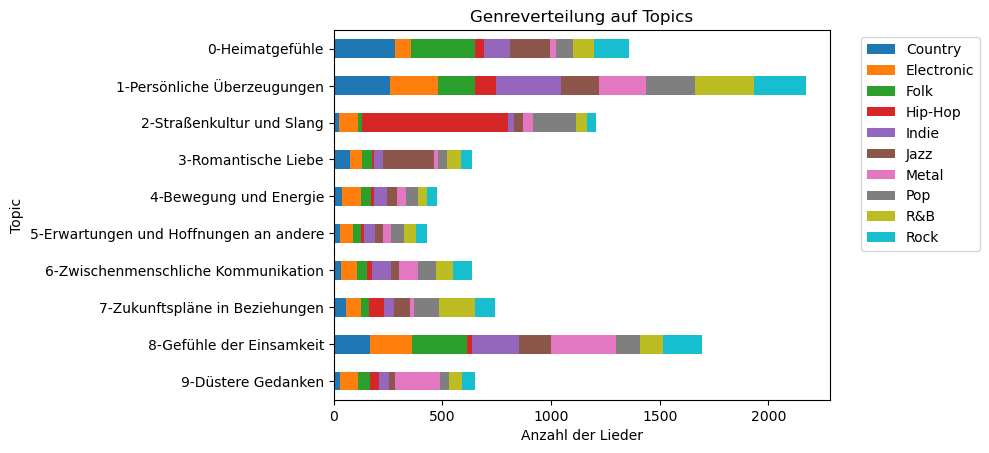

In [31]:
# Create a crosstab
crosstab = pd.crosstab(results['Dominant_Topic'].map(umbrella_topic_lookup), results['Genre']).sort_values(by="Dominant_Topic", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Anzahl der Lieder')
plt.ylabel('Topic')
plt.title('Genreverteilung auf Topics')
plt.show()

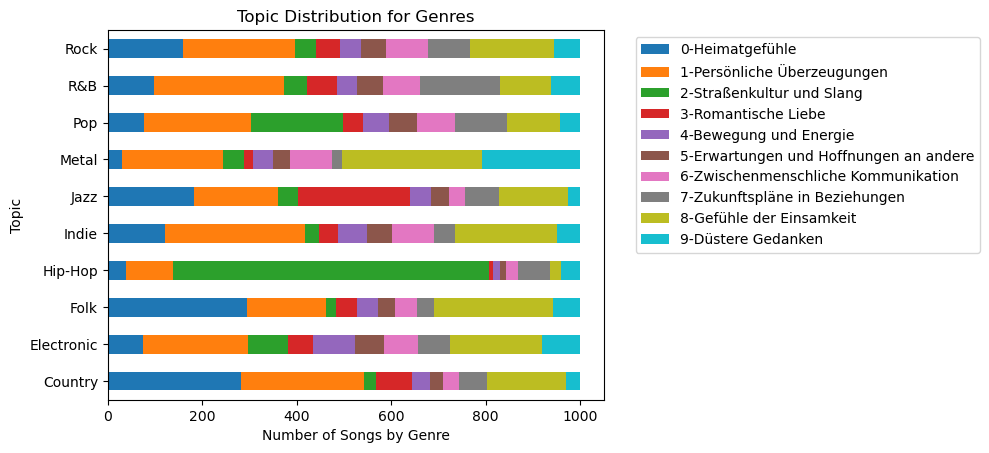

In [14]:
# Create a crosstab
crosstab = pd.crosstab(results['Genre'], results['Dominant_Topic'].map(umbrella_topic_lookup))

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Topic')
plt.title('Topic Distribution for Genres')
plt.show()

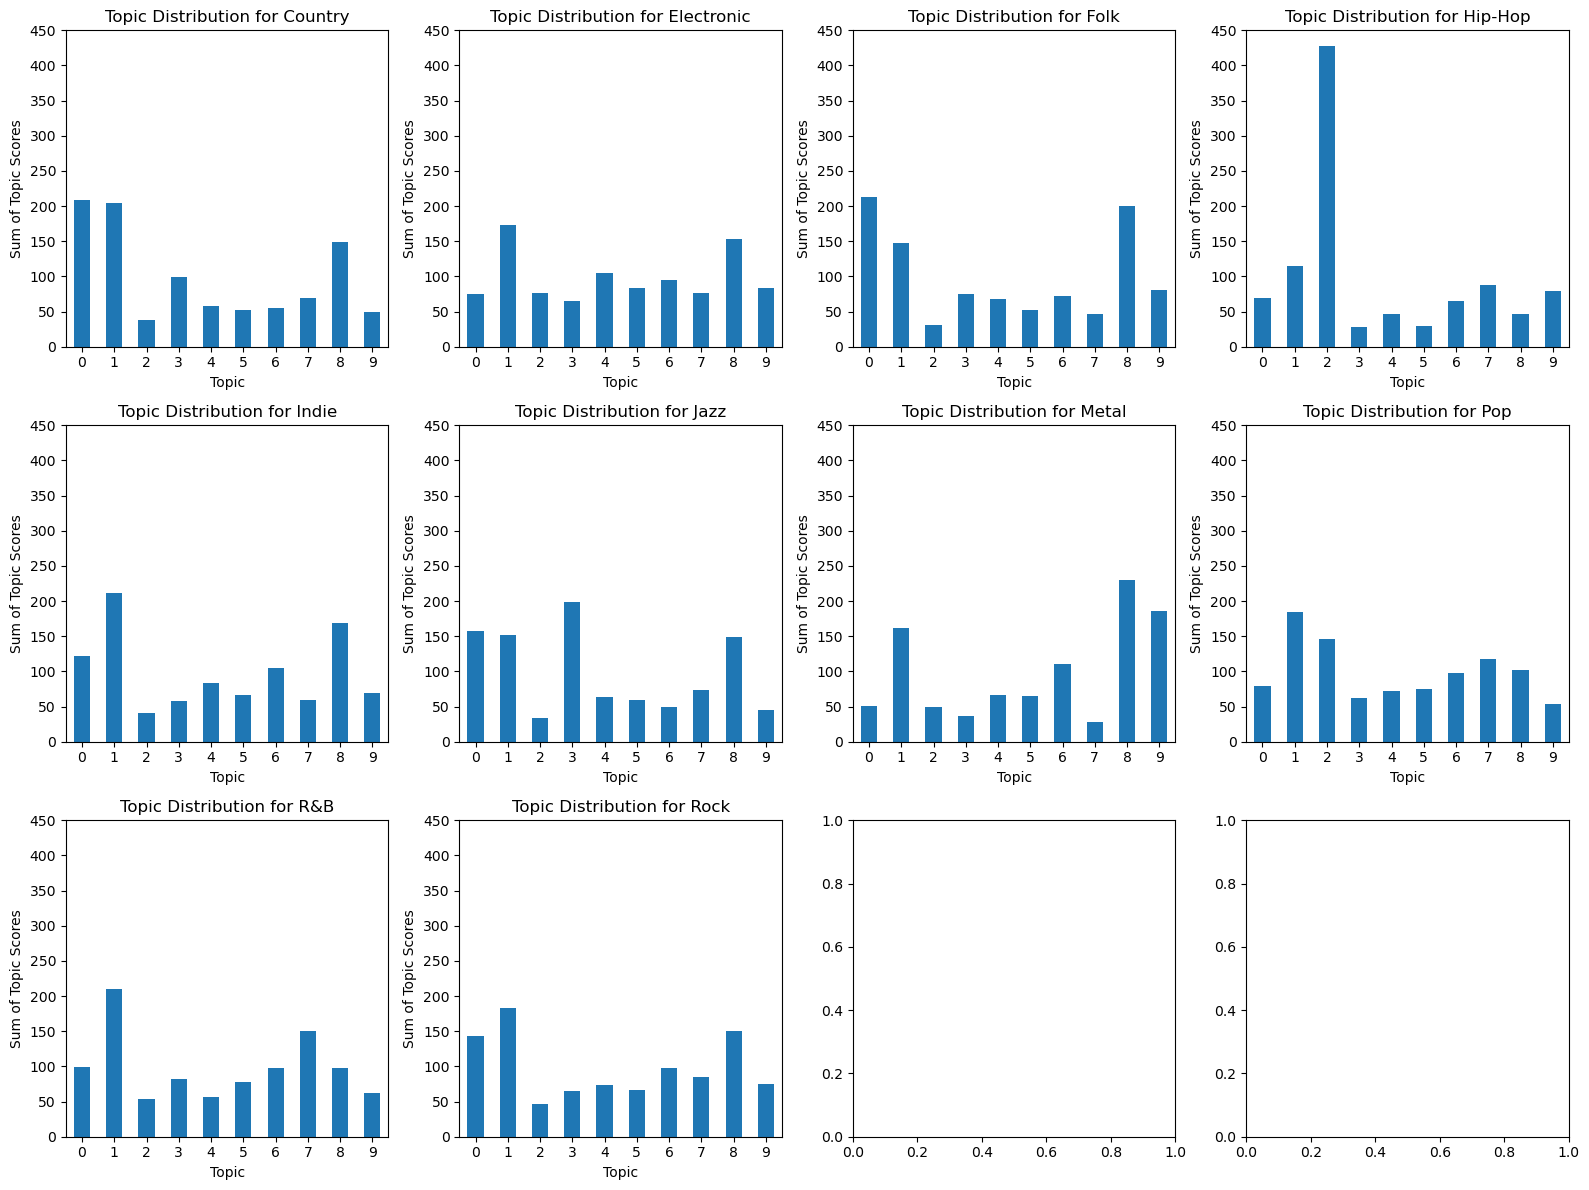

In [15]:
#Evaluate how many topics genres typically appear in (by summing up all the topic values instead of only looking at the most dominant one)
fig, axs = plt.subplots(3, 4, figsize=(16, 12))  # 3 rows, 4 columns

for i, genre in enumerate(genres):
    row = i // 4  # Row index
    col = i % 4   # Column index
    
    # Plotting
    results[results['Genre'] == genre][topic_columns].sum(axis=0).plot(kind='bar', ax=axs[row, col])
    axs[row, col].set_title(f'Topic Distribution for {genre}')
    axs[row, col].set_xlabel('Topic')
    axs[row, col].set_ylabel('Sum of Topic Scores')
    axs[row, col].tick_params(axis='x', rotation=0)  # Rotate x-labels for better readability
    axs[row][col].set_ylim(0, 450)  # Set y-axis limit
    

plt.tight_layout()
plt.show()

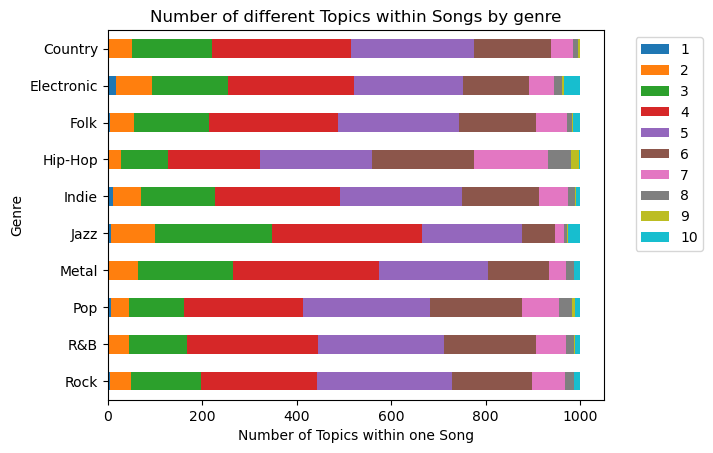

In [16]:
# Create a crosstab
crosstab = pd.crosstab(results['Genre'], results['NonZeroTopics']).sort_values(by="Genre", ascending=False)

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Topics within one Song')
plt.ylabel('Genre')
plt.title('Number of different Topics within Songs by genre')
plt.show()

#### Visualization (PCA) (visualizing LDA Results)

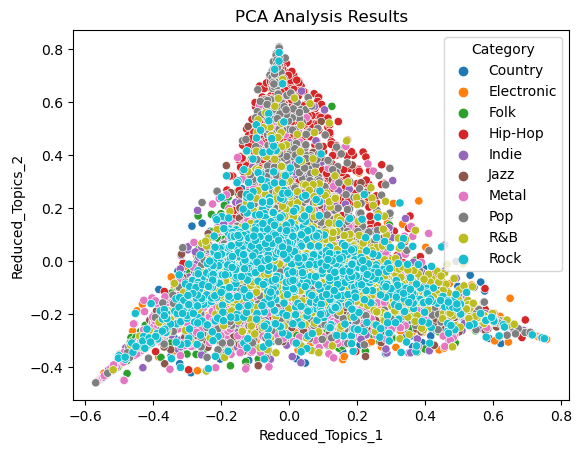

In [17]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(results[[i for i in range(0, num_topics)]])
results[['Reduced_Topics_1', 'Reduced_Topics_2']] = reduced
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

In [18]:
# # Create the subplot figure
# fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# # Iterate over genres and create scatter plots in each subplot
# for i, genre in enumerate(genres):
#     row = i // 4
#     col = i % 4
#     sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
#     axs[row][col].set_title(f'{genre} - PCA')
#     axs[row][col].legend(title='Category')
#     axs[row][col].set_xlim(-0.7, 0.7)  # Set x-axis limit
#     axs[row][col].set_ylim(-0.5, 0.75)  # Set y-axis limit

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

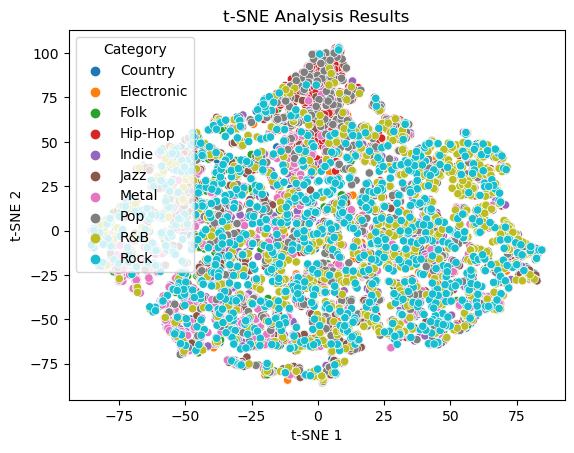

In [32]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the data to 2 dimensions
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
reduced = tsne.fit_transform(results[[i for i in range(0, num_topics)]])
results[['t-SNE 1', 't-SNE 2']] = reduced

#Scatter Plot
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Genre', data=results)
plt.title('t-SNE Analysis Results')
plt.legend(title='Category')
plt.show()

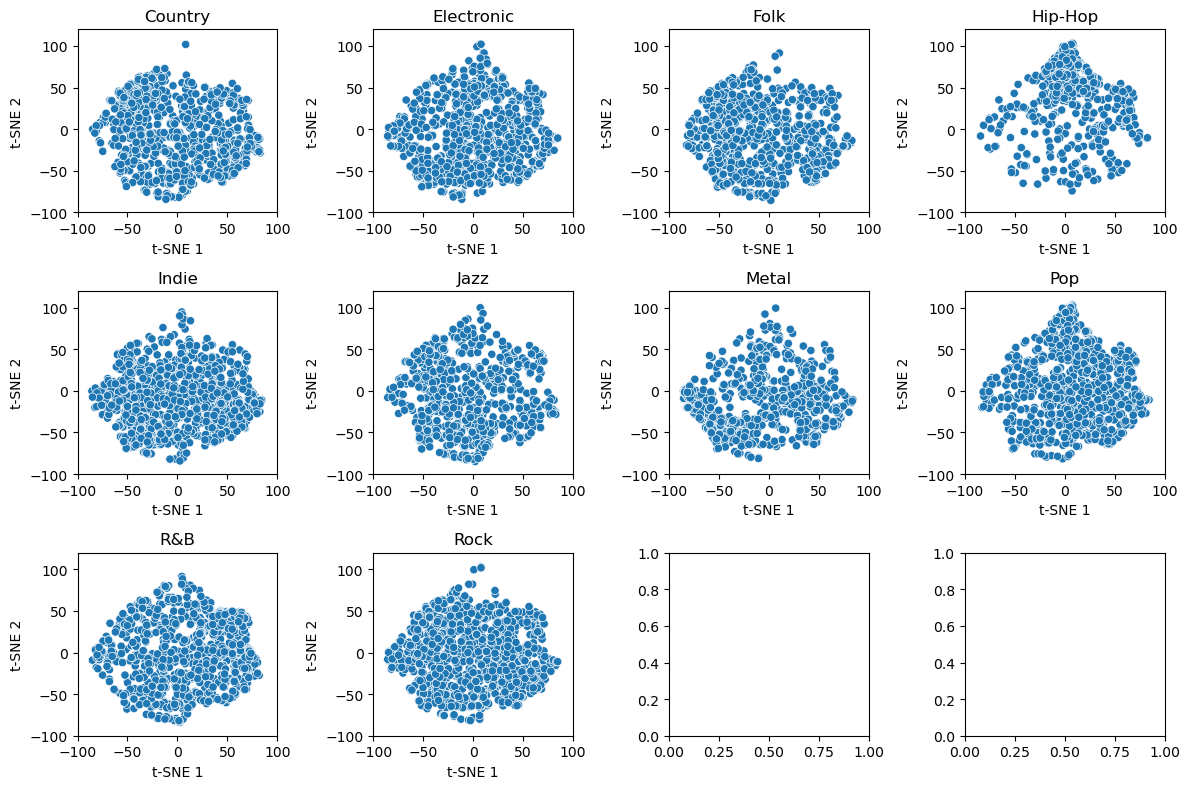

In [35]:
# Create the subplot figure
fig, axs = plt.subplots(3, 4, figsize=(12, 8))  # Adjust figsize as needed

# Iterate over genres and create scatter plots in each subplot
for i, genre in enumerate(genres):
    row = i // 4
    col = i % 4
    sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Genre', data=results[results['Genre'] == genre], ax=axs[row][col])
    axs[row][col].set_title(f'{genre}')
    axs[row][col].set_xlim(-100, 100)  # Set x-axis limit
    axs[row][col].set_ylim(-100, 120)  # Set y-axis limit
    axs[row][col].get_legend().remove()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

### Using Clustering

In [21]:
kmeans = KMeans(n_clusters=num_genres, random_state=0).fit(results[[i for i in range(0, num_topics)]])
results["Cluster"] = kmeans.labels_
results

c:\Users\anjan\anaconda3\envs\Studienarbeit\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Genre,Lyrics,0,1,2,3,4,5,6,7,8,9,Dominant_Topic,NonZeroTopics,Reduced_Topics_1,Reduced_Topics_2,Cluster
0,Country,goin girl writer bobby bond goin girl summerti...,0.000000,0.266757,0.071641,0.000000,0.000000,0.000000,0.000000,0.394076,0.246090,0.000000,7,4,70.723213,34.504284,6
1,Country,rather live life lies fantasy than face truth ...,0.107406,0.283561,0.000000,0.000000,0.189025,0.099175,0.000000,0.000000,0.306939,0.000000,8,5,-14.230650,-64.689148,1
2,Country,well making list st.nick tonight afraid what w...,0.087120,0.000000,0.000000,0.258992,0.000000,0.155424,0.000000,0.420491,0.058735,0.000000,7,5,49.604733,36.204681,6
3,Country,though gone away play your favorite song blue ...,0.423362,0.237056,0.000000,0.000000,0.000000,0.028630,0.000000,0.000000,0.296995,0.000000,0,4,-49.147728,15.093549,3
4,Country,"daddy little girl writers bobby burke, horace ...",0.490290,0.000000,0.000000,0.167493,0.000000,0.040951,0.000000,0.219875,0.000000,0.064146,0,5,-32.226120,49.328079,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Rock,said couldn find anyone love said there more l...,0.000000,0.285799,0.000000,0.000000,0.000000,0.000000,0.363313,0.168710,0.169673,0.000000,6,4,34.765160,7.541408,8
9996,Rock,caress inside bones caress inside bones house ...,0.225944,0.108888,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.643953,0.000000,8,3,-53.109478,-33.776615,1
9997,Rock,married fever hotter than pepper sprout been t...,0.397485,0.000000,0.132201,0.000000,0.088098,0.000000,0.000000,0.373390,0.000000,0.000000,0,4,-34.796898,62.206070,6
9998,Rock,open your eyes life time flies open light back...,0.074406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.617017,0.293354,0.000000,7,3,69.485092,42.023293,6


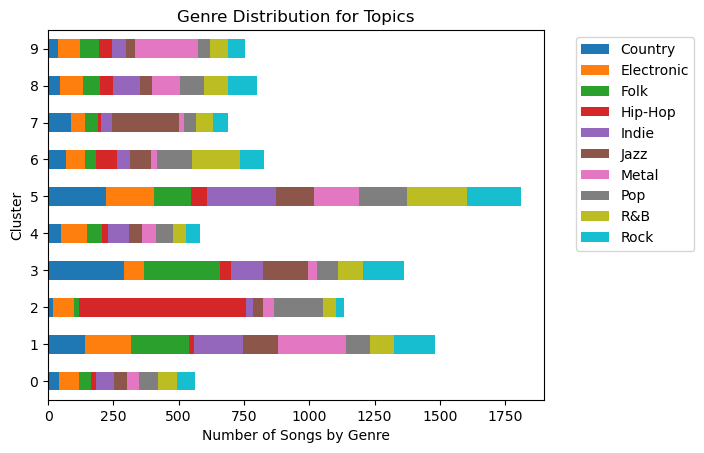

In [22]:
# Create a crosstab
crosstab = pd.crosstab(results['Cluster'], results['Genre'])

# Plot the crosstab
crosstab.plot(kind='barh', stacked=True).legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Number of Songs by Genre')
plt.ylabel('Cluster')
plt.title('Genre Distribution for Topics')
plt.show()

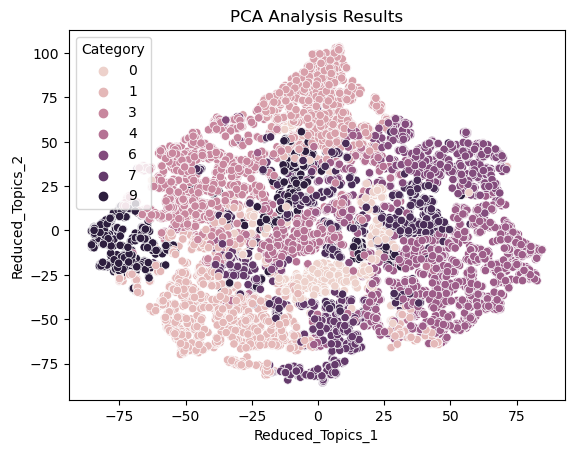

In [23]:
#Scatter Plot
sns.scatterplot(x='Reduced_Topics_1', y='Reduced_Topics_2', hue='Cluster', data=results)
plt.title('PCA Analysis Results')
plt.legend(title='Category')
plt.show()

### Trying to predict the genre based on the topic vector

In [24]:
X = results[[i for i in range(0, num_topics)]]
label_encoder = LabelEncoder()
results["GenreID"] = label_encoder.fit_transform(results["Genre"])
y = results["GenreID"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [25]:
#K-nearest neighbors
neigh = KNeighborsClassifier(n_neighbors=10)
neigh.fit(X_train, y_train)
neigh.score(X_test, y_test)

0.23966666666666667

In [26]:
#svm classifier
svc = SVC(kernel="linear")
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.273

In [27]:
#Random forest
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.25933333333333336

### Get Classification Matrix (of knn)

In [28]:
y_pred = svc.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.23      0.18      0.20       318
           1       0.20      0.16      0.18       308
           2       0.20      0.30      0.24       288
           3       0.52      0.68      0.59       303
           4       0.16      0.16      0.16       320
           5       0.30      0.32      0.31       290
           6       0.29      0.57      0.38       292
           7       0.24      0.04      0.07       292
           8       0.26      0.26      0.26       324
           9       0.15      0.07      0.09       265

    accuracy                           0.27      3000
   macro avg       0.26      0.27      0.25      3000
weighted avg       0.26      0.27      0.25      3000



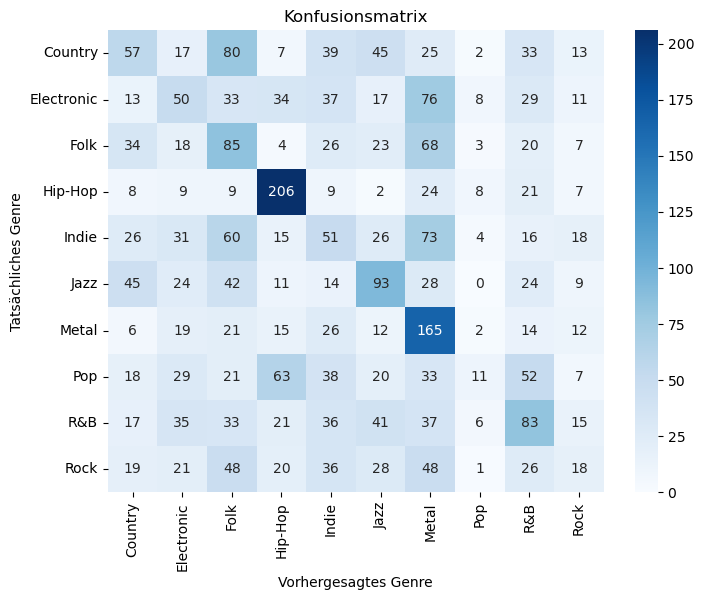

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)
# Get the class labels
class_labels = np.array([label_lookup.get(i) for i in svc.classes_])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Vorhergesagtes Genre')
plt.ylabel('Tatsächliches Genre')
plt.title('Konfusionsmatrix')
plt.show()

In [30]:
results[["Genre", "GenreID"]].drop_duplicates()

,Genre,GenreID
0,Country,0
1000,Electronic,1
2000,Folk,2
3000,Hip-Hop,3
4000,Indie,4
5000,Jazz,5
6000,Metal,6
7000,Pop,7
8000,R&B,8
9000,Rock,9


### Was hier gemacht wurde:
- Nehmen eines song subsets mit jeweils n songs aus jedem der m genres
- Bereinigen der Lyrics mit verschiedenen Preprocessing methoden (Best Practice)
- Using LDA to get most important topic based on all the songs
- applying the LDA topics to each song individually
- Investigating whether there is a correlation between the topics and the song genres, using crosstabs and, PCA-Scatterplots and Clustering
- Investigating whether it is possible to predict a genre based on its most prominent topics 

### Ergebnis
- Teils Zusammenhang zwischen prominenten Topics und Song Genres
- Vor Allem HipHop Topics fallen auffallend oft in die gleiche Kategorie
- Ergebnisse eindeutiger als bei der Vorherigen Lösung
- Vorhersage des Genres aus Topics nach wie vor nur schlecht möglich
- Einige Genres wie Folk und Pop sind extrem schwer vorherzusagen, was wohl bedeutet dass hier die Themenbereiche am wenigsten eingeschränkt sind
- Auf dem zweiten Platz ist Metall, was auch relativ gut vorhergesagt wird
- Die meisten Songs können relativ einfach einem Thema zugeordnet werden

### Interpretation
- Das Model funktioniert bereits besser als das vorherige. Die Vermutung liegt nahe, dass es zwischen manchen Genres mehr Unterschiede als zwischen anderen gibt. Ein gutes beispiel dafür ist HipHop, das sich relativ klar unterscheiden lässt.